https://harishnarayanan.org/writing/artistic-style-transfer/

In [1]:
import numpy as np

In [2]:
from neural_stylization.img_util import load_image, image_to_matrix, matrix_to_image, normalize, denormalize

Using TensorFlow backend.


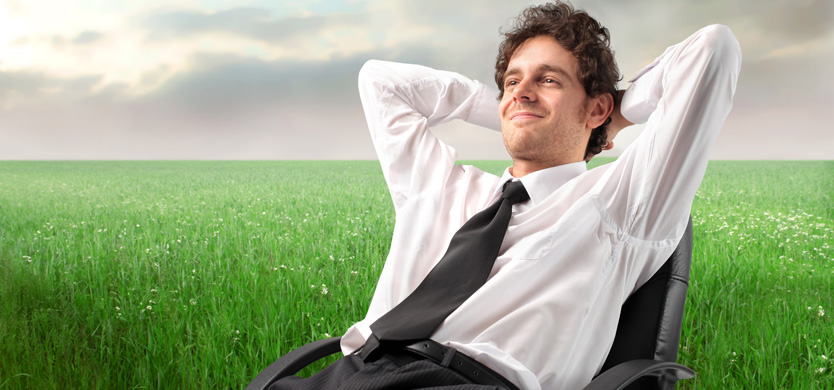

In [3]:
content = load_image('img/content/stock.jpg')
content

In [4]:
content = normalize(image_to_matrix(content))

In [5]:
content.shape

(1, 390, 834, 3)

In [6]:
height = content.shape[1]
width = content.shape[2]

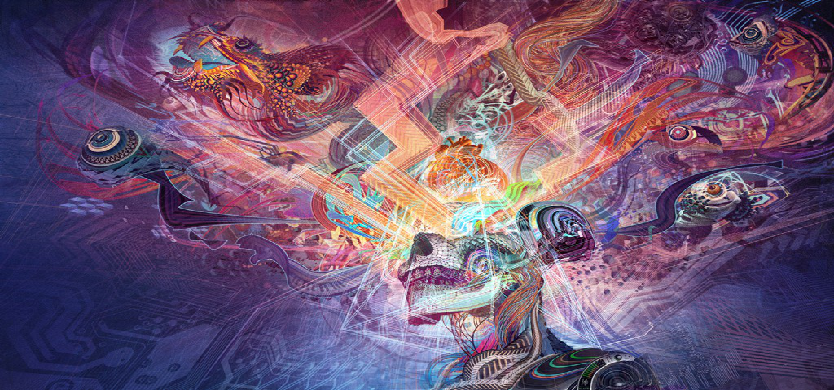

In [7]:
style = load_image('img/styles/android-jones-tipper.jpg', (width, height))
style

In [8]:
style = normalize(image_to_matrix(style))

In [9]:
from keras import backend

In [10]:
# load the variables into keras
content_image = backend.variable(content)
style_image = backend.variable(style)
combination_image = backend.placeholder((1, height, width, 3))

In [11]:
# concatentate the images into a single tensor
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [12]:
from neural_stylization.vgg19 import VGG_19

In [13]:
model = VGG_19(input_tensor=input_tensor, include_top=False)
model

VGG_19(include_top=False, weights=imagenet, input_tensor=Tensor("concat:0", shape=(3, 390, 834, 3), dtype=float32), input_shape=None, pooling=None, classes=1000)

In [14]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 390, 834, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 390, 834, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 195, 417, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 195, 417, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 195, 417, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 97, 208, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 97, 208, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 97, 208, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 97, 208, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 97, 208, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 48, 104, 256) dtype=float32>,
 'blo

In [15]:
# arbitrary weights that determine the relative importance of
# aspects of the machine
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

# Loss

In [16]:
# the variable for storing the loss
loss = backend.variable(0.)

## Content Loss

-  Gatys et al. (2015) - `block4_conv2`
-  Johnson et al. (2016) - `block2_conv2`

In [17]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block4_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features, combination_features)

## Style Loss

In [18]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [19]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# selections from Johnson 2016
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

## Variation Loss

In [20]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [21]:
grads = backend.gradients(loss, combination_image)

In [22]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [23]:
import time
from scipy.optimize import fmin_l_bfgs_b
import tensorflow as tf

In [24]:
# the initial set of random pixel values
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.0

In [25]:
iterations = 1

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 4.60368e+11
Iteration 0 completed in 388s


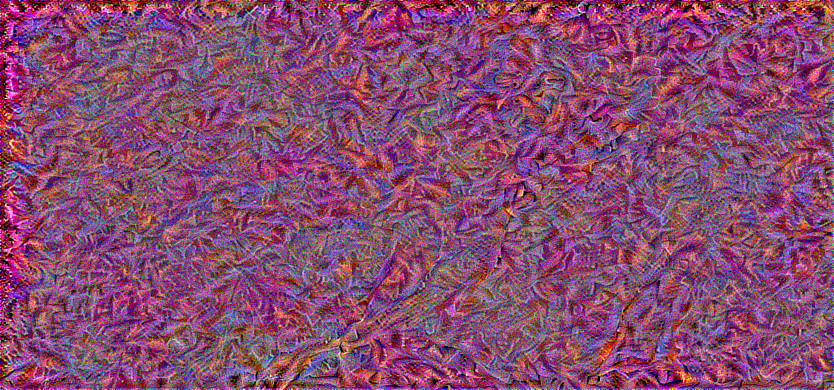

In [28]:
x = x.reshape((height, width, 3))
x = denormalize(x)
x = matrix_to_image(x)
x